In [9]:
import os
import numpy as np
import torch
from tqdm import tqdm
import json
from dual_network import Dual3DCNN6 as Dual
from decayLR import DecayLR
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
import re
import glob
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import torch


In [4]:
from utilities import list_patient_folders, prepare_data_nrrd, split_data

# Specify the directory where the patient folders are located
data_path_NEW = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton'
data_path_OLD = '/home/shahpouriz/Data/DBP_oldDATA/nrrd/proton'

# Get the list of patient folders

patient_list_NEW = list_patient_folders(data_path_NEW)
pct, rct, pos = prepare_data_nrrd(data_path_NEW, patient_list_NEW)
data_NEW = [{"plan": img[0], "repeat": tar, "pos": pos} for img, tar, pos in zip(pct, rct, pos)]


patient_list_OLD = list_patient_folders(data_path_OLD)
pct, rct, pos = prepare_data_nrrd(data_path_OLD, patient_list_OLD)
data_OLD = [{"plan": img[0], "repeat": tar, "pos": pos} for img, tar, pos in zip(pct, rct, pos)]


# Assuming data_NEW and data_OLD are your lists of dictionaries
data = data_NEW + data_OLD

# Split the data
train_data, val_data, test_data = split_data(data)

# Check the lengths of the sets
print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))




Number of training samples: 1832
Number of validation samples: 392
Number of test samples: 394


In [11]:
# Set parameters
starting_epoch = 0
decay_epoch = 20
final_epoch = 30
learning_rate = 0.0001
batchsize = 5
device_num = 1
lambda_reg = 0.000001

# Condition for saving list
save_list = False
best_mae = np.inf

exception_list = ['']


In [15]:
#### My method

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader

size = (256, 256, 256)
transforms = Compose([
        LoadImaged(keys=["plan", "repeat"], reader=ITKReader()),
        
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        ScaleIntensityRanged(
            keys=["plan", "repeat"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
        ),
        Spacingd(keys=["plan", "repeat"], pixdim=(2.0, 2.0, 2.0), mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=size),  # Ensure uniform size
    ])


train_ds = CacheDataset(data=train_data, transform=transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)



Loading dataset: 100%|██████████| 208/208 [00:43<00:00,  4.74it/s]


image shape: torch.Size([256, 256, 256]), target shape: torch.Size([256, 256, 256])


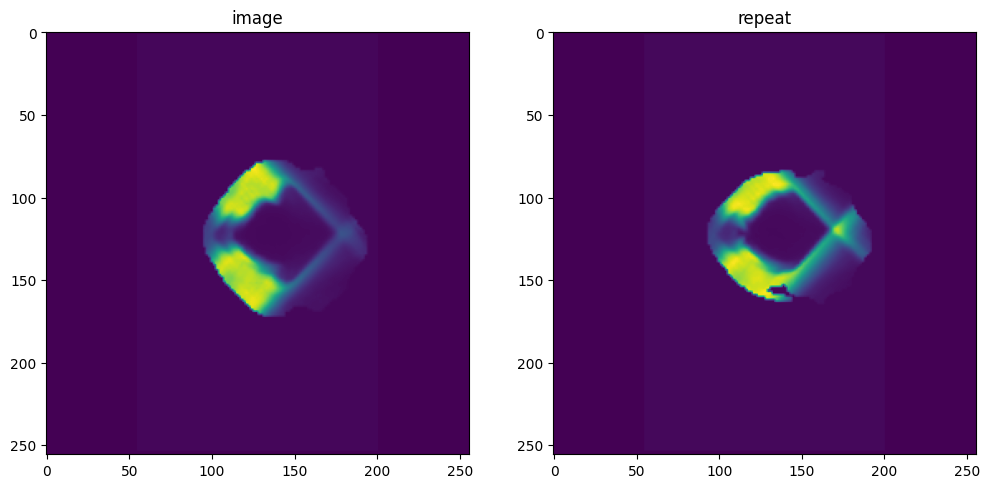

In [18]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
import matplotlib.pyplot as plt

# Assuming `transforms` is defined and `val_files` contains your validation files
check_ds = Dataset(data=val_data, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=1)

# Manually retrieve the first batch of data
for check_data in check_loader:
    break

plan, repeat = (check_data["plan"][0][0], check_data["repeat"][0][0])
print(f"image shape: {plan.shape}, target shape: {repeat.shape}")

# plot the slice [:, :, n]
n = 100

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(plan[:, :, n])
plt.subplot(1, 2, 2)
plt.title("repeat")
plt.imshow(repeat[:, :, n])
plt.show()

In [ ]:

# Build model
print('Initializing model...')
model = Dual(width=512, height=512, depth=512)
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss
print('Defining loss...')
mae_loss = torch.nn.L1Loss()
mse_loss = torch.nn.MSELoss()

# Define optimizer
print('Defining optimizer...')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Define scheduler
print('Defining scheduler...')
lr_lambda = DecayLR(epochs=final_epoch, offset=0, decay_epochs=decay_epoch).step
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


Initializing model...
Defining loss...
Defining optimizer...
Defining scheduler...


CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


In [ ]:
# Training loop
for epoch in range(starting_epoch, final_epoch):
    model.train()  # Set model to training mode
    mae_list = []
    train_loss = []
    for i, batch_data in enumerate(train_loader):  # Use enumerate to get the batch index
        pCT, rCT = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg = batch_data["pos"].clone().detach().requires_grad_(True).to(device)  # If gradients are required for 'reg'


        # Forward pass
        output = model(pCT, rCT)
        loss_output = mse_loss(output, reg)
            
        # L1 Regularization
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, param in model.named_parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        loss_output += lambda_reg * l1_reg
        
        # Backpropagation
        optimizer.zero_grad()  
        optimizer.step()
        
        # Logging
        mae_list.append(loss_output.item())
        mean_mae = np.mean(mae_list)
        # Corrected to print the current batch number
        print(f'Epoch: {epoch}/{final_epoch}, Batch: {i+1}/{len(train_loader)}, Loss_avg: {mean_mae}')

    # Validation loop
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch_data in val_loader:
            pCT_val, rCT_val = batch_data["plan"].to(device), batch_data["repeat"].to(device)
            reg_val = batch_data["pos"].clone().detach().requires_grad_(True).to(device)  # If gradients are required for 'reg'

            output_val = model(pCT_val, rCT_val)
            loss_val = mae_loss(output_val, reg_val)

            val_loss.append(loss_val.item())

            mean_val_loss = np.mean(val_loss)
            print(f'Epoch [{epoch+1}/{final_epoch}], Validation Loss: {mean_val_loss:.4f}')

    # Adjust learning rate
    lr_scheduler.step(mean_val_loss)
    
    save_dir = '/home/shahpouriz/Data/DBP_Project/LOG'
    loss_file = fr'/home/shahpouriz/Data/DBP_Project/LOG/loss_dose_json_simpleModel.txt'

    # Save model
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    current_valid_mae = val_loss[-1]    
    if current_valid_mae <= best_mae and epoch > 0:
        best_mae = current_valid_mae
        torch.save(model.state_dict(),f'{save_dir}/model_weights_dose_{epoch+1}.pt')
    with open(loss_file, 'a') as f: #a-append
        f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {mean_mae}, Val: {mean_val_loss}\n')


Epoch: 0/30, Batch: 1/100, Loss_avg: 0.18466401100158691
Epoch: 0/30, Batch: 2/100, Loss_avg: 0.10630710609257221
Epoch: 0/30, Batch: 3/100, Loss_avg: 0.5324986490110556
Epoch: 0/30, Batch: 4/100, Loss_avg: 0.6260357582941651
Epoch: 0/30, Batch: 5/100, Loss_avg: 0.6276227064430714
Epoch: 0/30, Batch: 6/100, Loss_avg: 0.538323612883687
Epoch: 0/30, Batch: 7/100, Loss_avg: 0.5180806150393826
Epoch: 0/30, Batch: 8/100, Loss_avg: 0.5124541162513196
Epoch: 0/30, Batch: 9/100, Loss_avg: 0.5449850637879636
Epoch: 0/30, Batch: 10/100, Loss_avg: 0.49518589563667775
Epoch: 0/30, Batch: 11/100, Loss_avg: 0.5066775588149374


KeyboardInterrupt: 

In [9]:
import torch
device = torch.device("cuda:0")
print("Using device:", device)



Using device: cuda:0
